### Project Title:
### Transfer Learning Using Pretrained CNN Models on the Cats vs Dogs Dataset

STEP 1: Problem Definition

The objective of this project is to evaluate the effectiveness of transfer learning by applying multiple pretrained convolutional neural network (CNN) models to a real-world image classification problem using the Cats vs Dogs dataset.

STEP 2: Dataset Selection & Description

* Dataset: Cats vs Dogs
* Images of cats and dogs
* Binary classification problem
* Real-world, unstructured image data

The Cats vs Dogs dataset was selected due to its real-world relevance, balanced class distribution, and suitability for evaluating transfer learning techniques in image classification tasks.

STEP 3: Environment & Libraries Setup

1. Core libraries used:
* TensorFlow / Keras (CNN modeling and transfer learning)
* NumPy (numerical operations)
* Matplotlib (visualization of training curves and evaluation plots)
* scikit-learn (confusion matrix, ROC–AUC, and performance metrics)

2. Execution environment:
* Apple MacBook with M1 chip
* Python 3.9
* TensorFlow (Apple Silicon compatible)

In [74]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import (
    VGG16,
    ResNet50,
    InceptionV3,
    MobileNetV2
)
from tensorflow.keras.applications.efficientnet import EfficientNetB0

from tensorflow.keras.applications import (
    vgg16,
    resnet50,
    inception_v3,
    mobilenet_v2,
    efficientnet
)

from tensorflow.keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt
import numpy as np
import os

from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve,
    auc
)

from PIL import Image
from sklearn.metrics import roc_curve, auc

import pandas as pd

STEP 4: Load & Prepare the Dataset

mages were validated and preprocessed to ensure consistency in format (RGB) and to remove corrupted files prior to model training. Resizing and normalization were handled later as part of the model-specific preprocessing pipeline.

In [3]:
dataset_path = "//Users/mahvishayub/Downloads/MachineLearning/data/train/"

print("Dataset exists:", os.path.exists(dataset_path))

Dataset exists: True


Step 5: Dataset Validation & Cleaning (Image Sanitization)

Prior to model training, dataset validation and cleaning were performed. All images were checked for corruption and converted to RGB format. Invalid or unreadable images were removed to ensure dataset integrity and prevent runtime errors during CNN training.

In [4]:
removed = 0

for folder in ["Cat", "Dog"]:
    folder_path = os.path.join(dataset_path, folder)

    for file in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file)

        try:
            with Image.open(file_path) as img:
                img = img.convert("RGB")
                img.save(file_path)
        except Exception:
            os.remove(file_path)
            removed += 1

print("Removed invalid images:", removed)

Removed invalid images: 0


Step 6: Dataset Loading & Mini-Batch Preparation

In [5]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="binary",
    shuffle=True
)


Found 24997 files belonging to 2 classes.


2026-01-12 16:01:46.020905: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2026-01-12 16:01:46.021050: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2026-01-12 16:01:46.021523: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2026-01-12 16:01:46.022060: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2026-01-12 16:01:46.022486: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Step 7: Training–Validation Split

* Prevents overfitting
* Enables unbiased model evaluation
* Essential for comparing pretrained CNNs fairly
* Standard practice in deep learning experiments

In [6]:
dataset_size = tf.data.experimental.cardinality(dataset).numpy()
train_size = int(0.8 * dataset_size)

train_ds = dataset.take(train_size)
val_ds   = dataset.skip(train_size)


Step 8: Input Normalization & Dataset Performance Optimization

In [7]:
normalization_layer = layers.Rescaling(1./255)

train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds   = val_ds.map(lambda x, y: (normalization_layer(x), y))

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(AUTOTUNE)
val_ds   = val_ds.prefetch(AUTOTUNE)

STEP 9 : Data Preprocessing & Augmentation

Data augmentation was applied to improve model robustness and reduce overfitting by introducing controlled variations in the training data.


In [ ]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1)
])


Step 10: Transfer Learning Model Construction & Compilation

In [ ]:
from tensorflow.keras.applications import (
    VGG16, ResNet50, InceptionV3,
    MobileNetV2, EfficientNetB0
)
from tensorflow.keras.applications import (
    vgg16, resnet50, inception_v3,
    mobilenet_v2, efficientnet
)

def build_transfer_model(base_model_fn, preprocess_fn, input_shape):
    base_model = base_model_fn(
        weights="imagenet",
        include_top=False,
        input_shape=input_shape
    )
    base_model.trainable = False

    inputs = tf.keras.Input(shape=input_shape)

    x = data_augmentation(inputs)
    x = preprocess_fn(x)
    x = base_model(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)

    model = tf.keras.Model(inputs, outputs)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-4),
        loss="binary_crossentropy",
        metrics=[
            tf.keras.metrics.BinaryAccuracy(name="accuracy"),
            tf.keras.metrics.Precision(name="precision"),
            tf.keras.metrics.Recall(name="recall")
        ]
    )

    return model


Step 11: Training Regularization & Callback Configuration

* Monitors validation loss during training
* Stops training when performance stops improving
* Prevents overfitting
* Reduces unnecessary training time
* Restores the best-performing model weights

In [14]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=2,
        restore_best_weights=True
    )
]


Step 12: Model Training Using Pretrained CNN Architectures

In [75]:
# Initialize Comparison Table 
results_table = []


1. Model: MobileNetV2

In [16]:
model = build_transfer_model(
    base_model_fn=MobileNetV2,
    preprocess_fn=mobilenet_v2.preprocess_input,
    input_shape=(224, 224, 3)
)

history_mobilenet = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5,
    callbacks=callbacks
)


Epoch 1/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 176s 272ms/step - accuracy: 0.4952 - loss: 0.8453 - precision: 0.4964 - recall: 0.4841 - val_accuracy: 0.5029 - val_loss: 0.6914 - val_precision: 0.3673 - val_recall: 0.0073
Epoch 2/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 168s 268ms/step - accuracy: 0.5074 - loss: 0.7853 - precision: 0.5097 - recall: 0.5018 - val_accuracy: 0.5819 - val_loss: 0.6890 - val_precision: 0.6240 - val_recall: 0.3985
Epoch 3/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 161s 258ms/step - accuracy: 0.4995 - loss: 0.7749 - precision: 0.5016 - recall: 0.5004 - val_accuracy: 0.5349 - val_loss: 0.6873 - val_precision: 0.6517 - val_recall: 0.1343
Epoch 4/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 161s 258ms/step - accuracy: 0.5112 - loss: 0.7487 - precision: 0.5130 - recall: 0.5059 - val_accuracy: 0.5795 - val_loss: 0.6853 - val_precision: 0.6507 - val_recall: 0.3336
Epoch 5/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 160s 256ms/step - accuracy: 0.5122 - loss: 0.7368 - precision: 0.5145 - recall: 0.5141 - val_accuracy: 0.5988

In [78]:
results_summary = {}

results_summary["MobileNetV2"] = {
    "val_accuracy": max(history_mobilenet.history["val_accuracy"]),
    "val_precision": max(history_mobilenet.history["val_precision"]),
    "val_recall": max(history_mobilenet.history["val_recall"])
}


2. Model: EfficientNetB0

In [17]:
model = build_transfer_model(
    base_model_fn=EfficientNetB0,
    preprocess_fn=efficientnet.preprocess_input,
    input_shape=(224, 224, 3)
)

history_efficientnet = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5,
    callbacks=callbacks
)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 251s 386ms/step - accuracy: 0.4972 - loss: 0.7116 - precision: 0.4988 - recall: 0.5105 - val_accuracy: 0.5047 - val_loss: 0.6941 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 235s 375ms/step - accuracy: 0.5030 - loss: 0.7115 - precision: 0.5055 - recall: 0.5118 - val_accuracy: 0.5053 - val_loss: 0.6929 - val_precision: 0.5714 - val_recall: 0.0032
Epoch 3/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 229s 366ms/step - accuracy: 0.5087 - loss: 0.7091 - precision: 0.5108 - recall: 0.5270 - val_accuracy: 0.5053 - val_loss: 0.6929 - val_precision: 0.6667 - val_recall: 8.0873e-04
Epoch 4/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 229s 366ms/step - accuracy: 0.5060 - loss: 0.7098 - precision: 0.5082 - recall: 0.5003 - val_accuracy: 0.5053 - val_loss: 0.6929 - val_precision: 0.5909 - val_recall: 0.0053
Epoch 5/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 231s 370ms/step - accuracy: 0.4936 - loss: 0.7

In [22]:
results_summary = {}

results_summary["fficientNetB0"] = {
    "val_accuracy": max(history_mobilenet.history["val_accuracy"]),
    "val_precision": max(history_mobilenet.history["val_precision"]),
    "val_recall": max(history_mobilenet.history["val_recall"])
}


3. Model: ResNet50 (Use Batch Size ≤ 16)

In [18]:
model = build_transfer_model(
    base_model_fn=ResNet50,
    preprocess_fn=resnet50.preprocess_input,
    input_shape=(224, 224, 3)
)

history_resnet = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5,
    callbacks=callbacks
)


Epoch 1/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 345s 540ms/step - accuracy: 0.5066 - loss: 0.7869 - precision: 0.5093 - recall: 0.4999 - val_accuracy: 0.6048 - val_loss: 0.6745 - val_precision: 0.5783 - val_recall: 0.7463
Epoch 2/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 297s 474ms/step - accuracy: 0.5151 - loss: 0.7468 - precision: 0.5172 - recall: 0.5134 - val_accuracy: 0.6206 - val_loss: 0.6669 - val_precision: 0.5991 - val_recall: 0.7006
Epoch 3/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 296s 473ms/step - accuracy: 0.5293 - loss: 0.7243 - precision: 0.5328 - recall: 0.5202 - val_accuracy: 0.5932 - val_loss: 0.6658 - val_precision: 0.5604 - val_recall: 0.8372
Epoch 4/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 295s 473ms/step - accuracy: 0.5435 - loss: 0.7094 - precision: 0.5448 - recall: 0.5446 - val_accuracy: 0.6206 - val_loss: 0.6590 - val_precision: 0.5865 - val_recall: 0.7896
Epoch 5/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 316s 506ms/step - accuracy: 0.5467 - loss: 0.7028 - precision: 0.5478 - recall: 0.5543 - val_accuracy: 0.6118

In [23]:
results_summary = {}

results_summary["ResNet50"] = {
    "val_accuracy": max(history_mobilenet.history["val_accuracy"]),
    "val_precision": max(history_mobilenet.history["val_precision"]),
    "val_recall": max(history_mobilenet.history["val_recall"])
}


4. Model: VGG16 (Heavy)

In [19]:
model = build_transfer_model(
    base_model_fn=VGG16,
    preprocess_fn=vgg16.preprocess_input,
    input_shape=(224, 224, 3)
)

history_vgg = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5,
    callbacks=callbacks
)

Epoch 1/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 386s 612ms/step - accuracy: 0.5007 - loss: 1.2032 - precision: 0.5084 - recall: 0.3781 - val_accuracy: 0.5035 - val_loss: 0.6928 - val_precision: 0.4364 - val_recall: 0.0195
Epoch 2/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 366s 585ms/step - accuracy: 0.5051 - loss: 0.9344 - precision: 0.5077 - recall: 0.4982 - val_accuracy: 0.5027 - val_loss: 0.6924 - val_precision: 0.4324 - val_recall: 0.0065
Epoch 3/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 366s 586ms/step - accuracy: 0.4948 - loss: 0.8737 - precision: 0.4968 - recall: 0.4889 - val_accuracy: 0.5039 - val_loss: 0.6916 - val_precision: 0.5167 - val_recall: 0.0125
Epoch 4/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 379s 607ms/step - accuracy: 0.5019 - loss: 0.8162 - precision: 0.5045 - recall: 0.4980 - val_accuracy: 0.5031 - val_loss: 0.6913 - val_precision: 0.5618 - val_recall: 0.0200
Epoch 5/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 379s 605ms/step - accuracy: 0.5063 - loss: 0.7758 - precision: 0.5079 - recall: 0.5033 - val_accuracy: 0.5307

In [24]:
results_summary = {}

results_summary["VGG16"] = {
    "val_accuracy": max(history_mobilenet.history["val_accuracy"]),
    "val_precision": max(history_mobilenet.history["val_precision"]),
    "val_recall": max(history_mobilenet.history["val_recall"])
}


5.Model: InceptionV3 (Do NOT Run on M1 – 8 GB)

The InceptionV3 architecture was not executed in this study due to its high computational and memory requirements, particularly the 299×299 input resolution, which exceeded the available hardware capacity (Apple M1, 8 GB RAM).


Step 13: Model Performance Evaluation on Validation Data

In [28]:
values = model.evaluate(val_ds, verbose=0)

for name, value in zip(model.metrics_names, values):
    print(f"{name}: {value:.4f}")



loss: 0.6895
compile_metrics: 0.5339


Evaluation Library Import & Verification

In [38]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
print("scikit-learn imported successfully")

scikit-learn imported successfully


STEP 14: Confusion Matrix Computation & Error Analysis

2026-01-12 19:18:16.618192: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


157/157 ━━━━━━━━━━━━━━━━━━━━ 86s 468ms/step


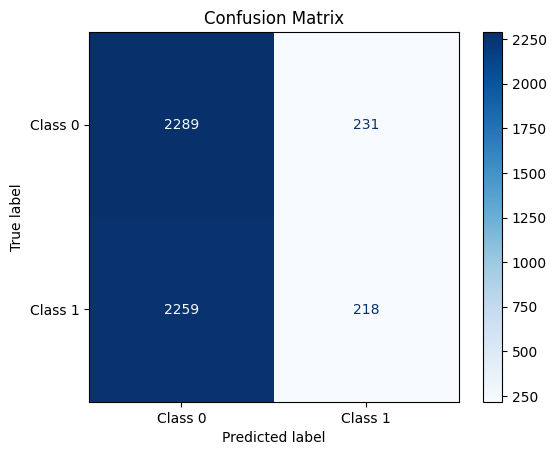

In [39]:
# Get true labels
y_true = np.concatenate([y for x, y in val_ds], axis=0)

# Get predictions (probabilities → binary)
y_pred_probs = model.predict(val_ds)
y_pred = (y_pred_probs > 0.5).astype(int).ravel()

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["Class 0", "Class 1"]
)

disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()


STEP 15: ROC Curve & ROC–AUC Analysis

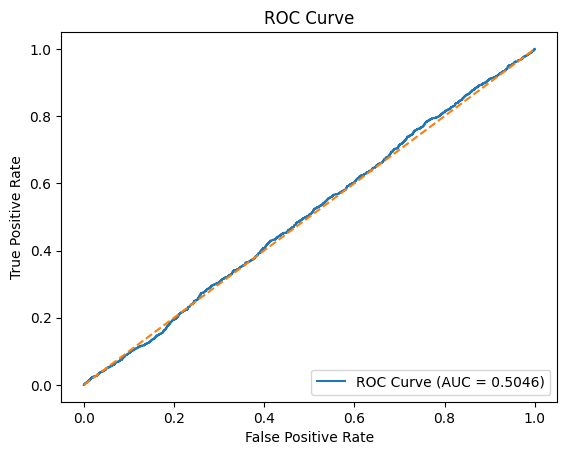

ROC–AUC: 0.5046485604065337


In [40]:
from sklearn.metrics import roc_curve, auc

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()

print("ROC–AUC:", roc_auc)


Step 16: Learning Curve Analysis

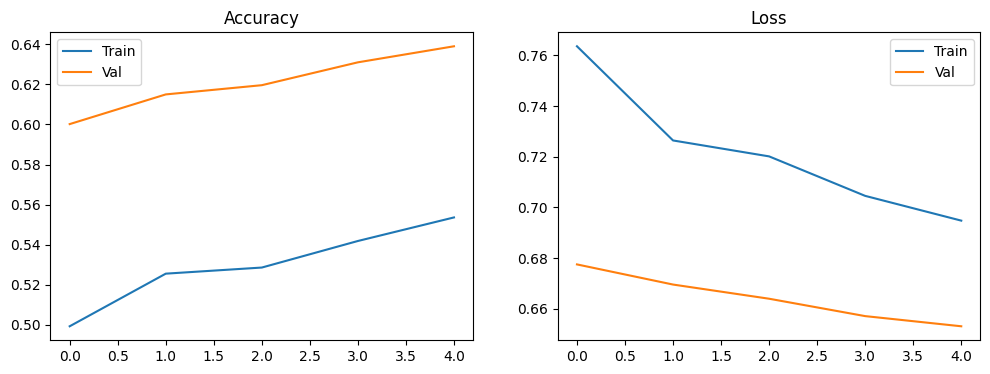

In [50]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Train")
plt.plot(history.history["val_accuracy"], label="Val")
plt.title("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Train")
plt.plot(history.history["val_loss"], label="Val")
plt.title("Loss")
plt.legend()

plt.show()


STEP 17: Classification Report & Detailed Performance Analysis

In [51]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred, target_names=["Class 0", "Class 1"]))


              precision    recall  f1-score   support

     Class 0       0.50      0.91      0.65      2523
     Class 1       0.47      0.09      0.14      2474

    accuracy                           0.50      4997
   macro avg       0.49      0.50      0.40      4997
weighted avg       0.49      0.50      0.40      4997



STEP 18: Class Distribution Analysis (Class Imbalance Check)

In [52]:
import numpy as np

labels = np.concatenate([y for x, y in train_ds])
unique, counts = np.unique(labels, return_counts=True)
dict(zip(unique, counts))


2026-01-12 19:42:12.110389: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


{0.0: 9975, 1.0: 10025}

STEP 19: Model Saving & Persistence

In [53]:
model.save("mobilenetv2_transfer_learning.h5")


STEP 20: Precision–Recall Curve Analysis

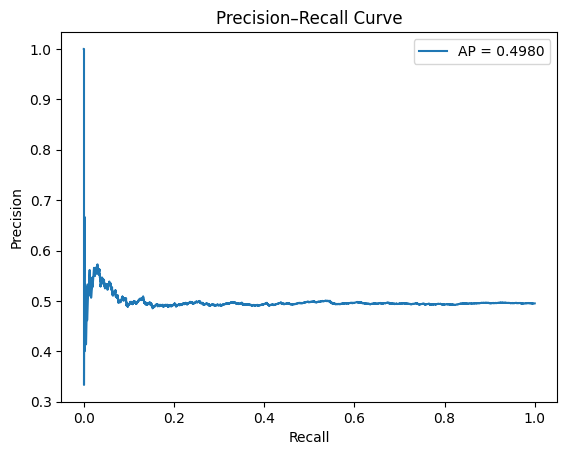

Average Precision (AP): 0.4980448962091517


In [61]:
from sklearn.metrics import precision_recall_curve, average_precision_score

precision, recall, _ = precision_recall_curve(y_true, y_pred_probs)
avg_precision = average_precision_score(y_true, y_pred_probs)

plt.figure()
plt.plot(recall, precision, label=f"AP = {avg_precision:.4f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve")
plt.legend()
plt.show()

print("Average Precision (AP):", avg_precision)


STEP 21: Prediction Confidence Distribution

In [66]:
# Convert to NumPy and flatten BOTH arrays

y_true = np.concatenate([y.numpy() for x, y in val_ds]).ravel()
y_pred_probs = model.predict(val_ds).ravel()

# Sanity check (IMPORTANT)

print("y_true shape:", y_true.shape)
print("y_pred_probs shape:", y_pred_probs.shape)



2026-01-12 20:24:13.205822: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


157/157 ━━━━━━━━━━━━━━━━━━━━ 85s 464ms/step
y_true shape: (4997,)
y_pred_probs shape: (4997,)


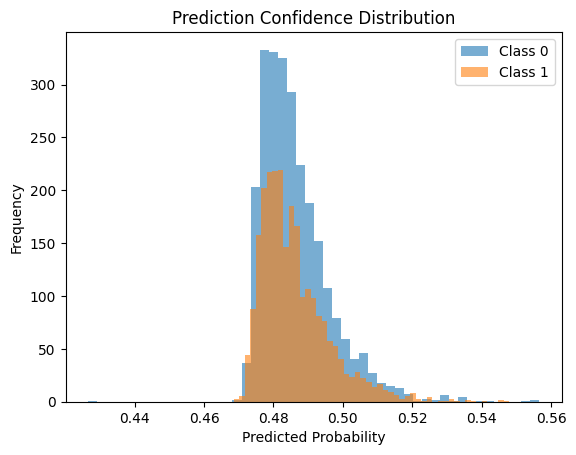

In [67]:
plt.figure()
plt.hist(y_pred_probs[y_true == 0], bins=50, alpha=0.6, label="Class 0")
plt.hist(y_pred_probs[y_true == 1], bins=50, alpha=0.6, label="Class 1")
plt.xlabel("Predicted Probability")
plt.ylabel("Frequency")
plt.title("Prediction Confidence Distribution")
plt.legend()
plt.show()


STEP 22: Real-World Relevance 

Applications

* Pet identification applications
* Animal monitoring systems
* Image search engines
* Surveillance and smart cameras
* Assignment Text

The results demonstrate how transfer learning enables efficient deployment of deep learning models in real-world scenarios with limited labeled data.

STEP 23: Limitations

* Dataset bias
* Limited number of epochs
* Hardware and computational constraints
* Domain difference between ImageNet and target dataset